In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#DATA SOURCE

In [91]:
File_source = '../Data/nypd-motor-vehicle-collisions.csv'

In [ ]:
# Definicja zbiorów danych:
#     czynniki INJURED oznacza sumę rannych dla danego ID wypadku
#     czynniki KILLED oznacza sumę zabitych dla danego ID wypadku
#     czynniki zostaną połączone znakiem "||" - każde jego wystąpienie oznacza udział dodatkowego pojazdu w wypadku

In [4]:
columns = ['ACCIDENT DATE', 'ACCIDENT TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']
ranni = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED',  'NUMBER OF MOTORIST INJURED']
zabici = ['NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED']
czynniki = ['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5']
dzielnica = ['BOROUGH']
czas = ['ACCIDENT DATE', 'ACCIDENT TIME']

In [92]:
df = pd.read_csv(File_source)

/tmp/ipykernel_23378/1857041183.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(File_source)


In [1]:
# DLA NAJNIEBEZPIECZNIEJSZYH WYPADKÓW ZASTOSOWANO PODEJŚCIE: 
#     zgodnie z ustawą o rucho drogowym "Miejsce niebezpieczne oznacza liczbę mnogą wypadków śmiertelnych" zatem najniebespieczniejsze czynniki wypadków muszą kończyć sie skutkiem smiertelnym
#         istnieją dwa główne powody takiej interpretacji: 
#         1. bez dostępu do osób tworzących dokumentacje i wporwadzających dane do zbioru nie wiem co oznaczają komórki puste w czynnikach dla danego ID, nie wiemy co oznacza pojęcie UNSPECYFIED, nie wiemy też jakie jest źródło wystąpienia wartości nan i NaN
#         2. zgodnie z ilościową teorią informacji Shanona najmniejsza porcja danych niesie ze sobą najwięszky poziom wiedzy - literalnie najmniejszy poziom niepewności zatem najmniejsza porcja pewnych danych to informacja o zgonach w wyniku wypadku. Nie pezesądza o całym zbiorze ale niesie pewną infromację co do częsci rekordów.
# Definicja: niebezpieczne czynniki wypadków to takie, które spowodowały najwięszkszą liczbę zgonów i jednocześnie spowodowały inne obrażenia. Oznacza to, żę nie koniecznie dany czynnik najczęściej powoduje skutek śmiertelny ale w Nowym Jorku, ale żę populacja miasta ginie w największej liczbie od danego czynnika 

Liczba unikalnych ID po usunięciu duplikatów: 773421
Śmiertelność wypadków w zestawieniu z innymi obrażeniami:
Faktor: Driver Inattention/Distraction, Suma KILLED: 299.0, Suma INJURED: 95549.0
Faktor: Failure to Yield Right-of-Way, Suma KILLED: 238.0, Suma INJURED: 53245.0
Faktor: Traffic Control Disregarded, Suma KILLED: 236.0, Suma INJURED: 18330.0
Faktor: Unsafe Speed, Suma KILLED: 204.0, Suma INJURED: 10140.0
Faktor: Pedestrian/Bicyclist/Other Pedestrian Error/Confusion, Suma KILLED: 72.0, Suma INJURED: 5108.0


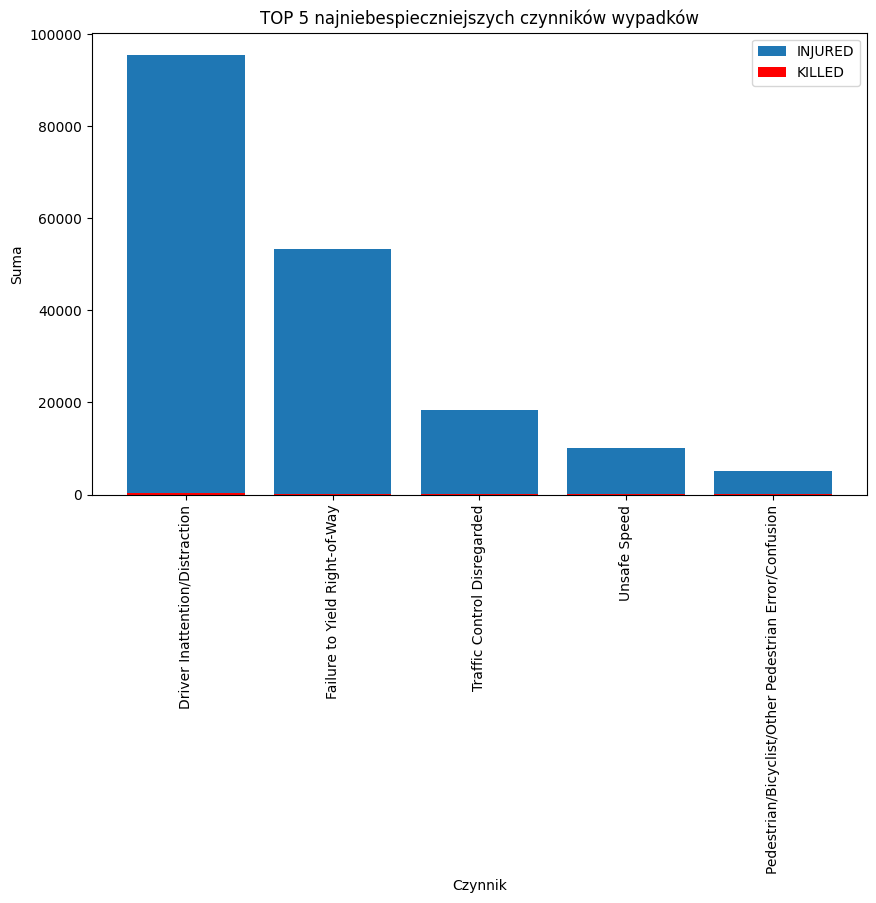

In [115]:
# BLOK RESERT
# import pandas as pd
# import matplotlib.pyplot as plt
# File_source = '../Data/nypd-motor-vehicle-collisions.csv'
# df = pd.read_csv(File_source)

# DUPLIKATY
df.drop_duplicates(subset='COLLISION_ID', keep='first', inplace=True)
num_unique_ids = df['COLLISION_ID'].nunique()
print("Liczba unikalnych ID po usunięciu duplikatów:", num_unique_ids)

# BLOK ZBIORU DANYCH
zabici = ['NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED']
df['KILLED'] = df[zabici].sum(axis=1, skipna=True)
ranni = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF MOTORIST INJURED']
df['INJURED'] = df[ranni].sum(axis=1, skipna=True)
czynniki = ['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5']
df['FAKTORS'] = df[czynniki].astype(str).apply(lambda x: ' || '.join(filter(lambda y: y != 'Unspecified' and y != 'nan' and y != 'NaN' and y.strip() != '', x)), axis=1)
df = df[df['FAKTORS'] != '']

# Grupowanie
grouped_killed = df.groupby('FAKTORS')['KILLED'].sum()
grouped_injured = df.groupby('FAKTORS')['INJURED'].sum()
top_5_faktors = grouped_killed.nlargest(5)

# Wyświetlenie
print("Śmiertelność wypadków w zestawieniu z innymi obrażeniami:")
for faktor, faktor_killed_sum, faktor_injured_sum in zip(top_5_faktors.index, top_5_faktors.values, grouped_injured[top_5_faktors.index].values):
    print(f"Faktor: {faktor}, Suma KILLED: {faktor_killed_sum}, Suma INJURED: {faktor_injured_sum}")

# WYKRES    
plt.figure(figsize=(10, 6))
plt.bar(top_5_faktors.index, grouped_injured[top_5_faktors.index], label='INJURED')
plt.bar(top_5_faktors.index, top_5_faktors.values, label='KILLED', color='red')
plt.xlabel('Czynnik')
plt.ylabel('Suma')
plt.title('TOP 5 najniebespieczniejszych czynników wypadków')
plt.legend()
plt.xticks(rotation=90)

plt.show()

In [3]:
# WNIOSKI: 
#     najniebezpieczniejsze czynniki są z udziałem pojedynczego pojazdu mechanicznego:
# 1. Driver Inattention/Distraction KILLED 
# 2 .Failure to Yield Right-of-Way, Suma KILLED
# 3. Traffic Control Disregarded, Suma KILLED
# 4. FUnsafe Speed, Suma KILLED
# 5. Pedestrian/Bicyclist/Other Pedestrian Error/Confusion

Liczba unikalnych ID po usunięciu duplikatów: 773421
UŚmiertelność wypadków w zestawieniu z innymi obrażeniami dla dzielnicy BRONX:
Faktor: Failure to Yield Right-of-Way, Suma KILLED: 28.0, Suma INJURED: 5091.0
Faktor: Driver Inattention/Distraction, Suma KILLED: 22.0, Suma INJURED: 7343.0
Faktor: Traffic Control Disregarded, Suma KILLED: 22.0, Suma INJURED: 1896.0
Faktor: Passenger Distraction, Suma KILLED: 10.0, Suma INJURED: 652.0
Faktor: Following Too Closely, Suma KILLED: 8.0, Suma INJURED: 2104.0


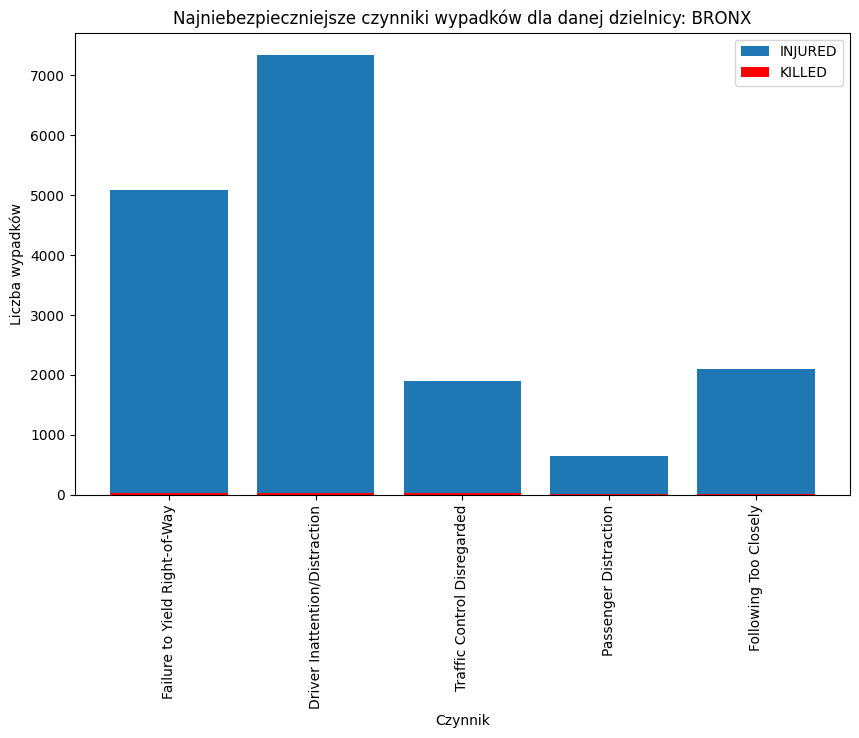

In [117]:
# BLOK RESERT
# import pandas as pd
# import matplotlib.pyplot as plt
# File_source = '../Data/nypd-motor-vehicle-collisions.csv'
# df = pd.read_csv(File_source)

# DUPLIKATY
df.drop_duplicates(subset='COLLISION_ID', keep='first', inplace=True)
num_unique_ids = df['COLLISION_ID'].nunique()
print("Liczba unikalnych ID po usunięciu duplikatów:", num_unique_ids)

# BLOK ZBIORU DANYCH
filtered_df = df[df['BOROUGH'] == 'BRONX'].copy()
zabici = ['NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED']
filtered_df.loc[:, 'KILLED'] = filtered_df[zabici].sum(axis=1, skipna=True)
ranni = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF MOTORIST INJURED']
filtered_df.loc[:, 'INJURED'] = filtered_df[ranni].sum(axis=1, skipna=True)
czynniki = ['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5']
filtered_df.loc[:, 'FAKTORS'] = filtered_df[czynniki].astype(str).apply(lambda x: ' || '.join(filter(lambda y: y != 'Unspecified' and y != 'nan' and y != 'NaN' and y.strip() != '', x)), axis=1)
filtered_df = filtered_df[filtered_df['FAKTORS'] != '']

# Grupowanie 
grouped_killed = filtered_df.groupby('FAKTORS')['KILLED'].sum()
grouped_injured = filtered_df.groupby('FAKTORS')['INJURED'].sum()
top_5_faktors = grouped_killed.nlargest(5)

# Wyświetlenie 
print("UŚmiertelność wypadków w zestawieniu z innymi obrażeniami dla dzielnicy BRONX:")
for faktor, faktor_killed_sum, faktor_injured_sum in zip(top_5_faktors.index, top_5_faktors.values, grouped_injured[top_5_faktors.index].values):
    print(f"Faktor: {faktor}, Suma KILLED: {faktor_killed_sum}, Suma INJURED: {faktor_injured_sum}")
    
# WYKRES    
plt.figure(figsize=(10, 6))
plt.bar(top_5_faktors.index, grouped_injured[top_5_faktors.index], label='INJURED')
plt.bar(top_5_faktors.index, top_5_faktors.values, label='KILLED', color='red')
plt.xlabel('Czynnik')
plt.ylabel('Liczba wypadków')
plt.title('Najniebezpieczniejsze czynniki wypadków dla danej dzielnicy: BRONX')
plt.legend()
plt.xticks(rotation=90)

plt.show()

In [ ]:
# WNIOSKI:
# dla dzielnicy BRONX najgorsze czynniki to:
#     Failure to Yield Right-of-Way
#     Driver Inattention/Distraction
#     Traffic Control Disregarded
#     Passenger Distraction
#     Following Too Closely
# również występują z udziałem jednego pojazdu zatem wstępnie dla NY źródłem śmiertelności może być przedewszystkim bezpośrednie narażenie na zdeżenie ciała człowieka z pojazdem mechanicznym
# Powyższą analizę można łątwo przestawić na inne dzielnice modyfikując linie kodu: filtered_df = df[df['BOROUGH'] == 'BRONX'].copy()

In [ ]:
# DLA PONIŻSZYCH WYKRESÓW PRZYJĘTO NASTĘPUJACĄ DEFINICJĘ Z SYSTEMU PRAWA COMMON LAW:
#     "Aggressive Driving" is defined as operating a motor. vehicle in violation of any speed law and a violation of. two or more of the following traffic law provisions: 
#         1) obedience to traffic control devices; 
#         2) overtaking on. the right; 
#         3) driving within a traffic lane; 
#         4) following.
# source: https://newsroom.aaa.com/wp-content/uploads/2020/12/Aggressive-Driving-Laws-Chart_vFINAL.pdf
        
# The National Highway Traffic and Safety Administration's (NHTSA's) definition of aggressive driving is 
# "a combination of moving traffic offenses to endanger other persons or property." 
# Put more simply, aggressive driving is engaging in risky behavior that ignores the safety of others.        

# source: https://www.progressive.com/answers/what-is-aggressive-driving/
        
# WNIOSEK: JEDYNA PASUJĄCA KATEGORIA TO 'Aggressive Driving/Road Rage'
#         parafrazując powyższe definicje oznacza sytuację analogiczną do polskiego systemu prawa, czyli nie dostosowanie prędkości do sytuacji na dordzę nawet jeśli mieściła się w lokalnym limicie

# WYKRES NUMER DWA MOŻNA ŁATWO PRZESTAWIĆ NA INNĄ DZIELNICĘ:
#     df_manhattan = df[df['BOROUGH'] == 'MANHATTAN'].copy()

Liczba unikalnych ID po usunięciu duplikatów: 773421


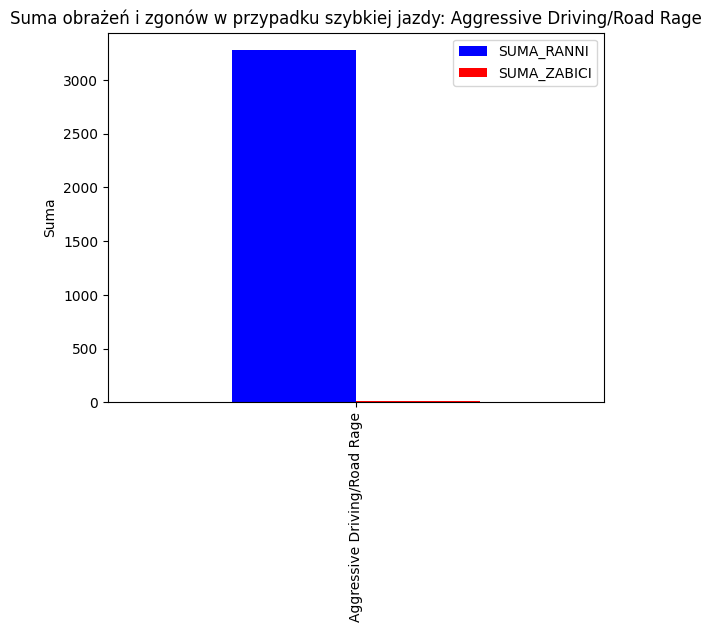

                              SUMA_RANNI  SUMA_ZABICI
FAKTORS                                              
Aggressive Driving/Road Rage      3277.0         14.0


In [124]:
# BLOK RESERT
# import pandas as pd
# import matplotlib.pyplot as plt
# File_source = '../Data/nypd-motor-vehicle-collisions.csv'
# df = pd.read_csv(File_source)

# DUPLIKATY
df.drop_duplicates(subset='COLLISION_ID', keep='first', inplace=True)
num_unique_ids = df['COLLISION_ID'].nunique()
print("Liczba unikalnych ID po usunięciu duplikatów:", num_unique_ids)

# BLOK ZBIORU DANYCH
ranni = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF MOTORIST INJURED']
zabici = ['NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED']
czynniki = ['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5']
filtered_df.loc[:, 'FAKTORS'] = filtered_df[czynniki].astype(str).apply(lambda x: ' || '.join(filter(lambda y: y != 'Unspecified' and y != 'nan' and y != 'NaN' and y.strip() != '', x)), axis=1)
filtered_df = filtered_df[filtered_df['FAKTORS'] != '']


df['SUMA_RANNI'] = df[ranni].sum(axis=1, skipna=True)
df['SUMA_ZABICI'] = df[zabici].sum(axis=1, skipna=True)

# WYKRES  
fig, ax = plt.subplots()
df_agg = df.groupby('FAKTORS')[['SUMA_RANNI', 'SUMA_ZABICI']].sum()
df_agg = df_agg[df_agg.index == 'Aggressive Driving/Road Rage']
df_agg.plot(kind='bar', ax=ax, color=['blue', 'red'])
plt.xlabel('')
plt.ylabel('Suma')
plt.title('Suma obrażeń i zgonów w przypadku szybkiej jazdy: Aggressive Driving/Road Rage')
plt.xticks(rotation=90) 
plt.show()

print(df_agg)

Liczba unikalnych ID po usunięciu duplikatów: 773421
Liczba unikalnych ID w dzielnicy MANHATTAN po usunięciu duplikatów: 135311


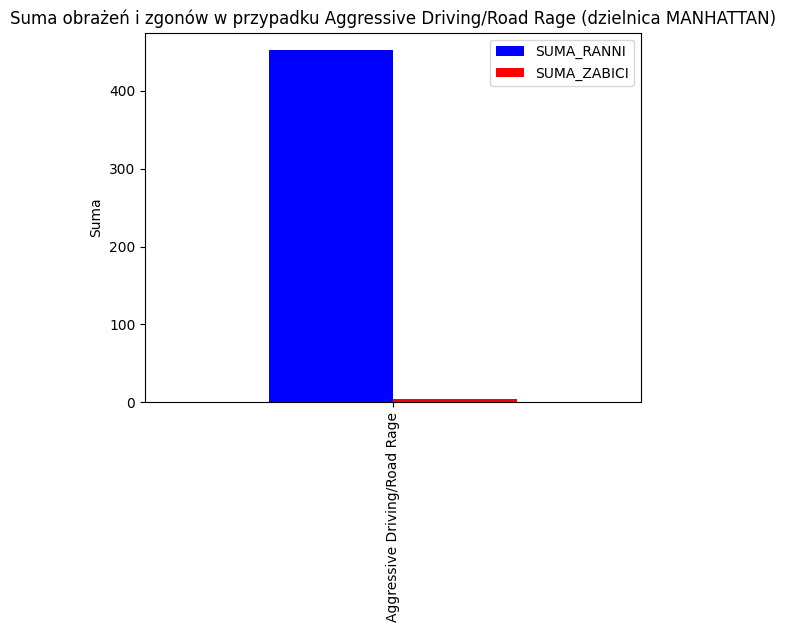

                              SUMA_RANNI  SUMA_ZABICI
FAKTORS                                              
Aggressive Driving/Road Rage       452.0          4.0


In [123]:
# BLOK RESERT
# import pandas as pd
# import matplotlib.pyplot as plt
# File_source = '../Data/nypd-motor-vehicle-collisions.csv'
# df = pd.read_csv(File_source)

# DUPLIKATY
df.drop_duplicates(subset='COLLISION_ID', keep='first', inplace=True)
num_unique_ids = df['COLLISION_ID'].nunique()
print("Liczba unikalnych ID po usunięciu duplikatów:", num_unique_ids)

# BLOK ZBIORU DANYCH
df_manhattan = df[df['BOROUGH'] == 'MANHATTAN'].copy()
num_unique_ids_manhattan = df_manhattan['COLLISION_ID'].nunique()
print("Liczba unikalnych ID w dzielnicy MANHATTAN po usunięciu duplikatów:", num_unique_ids_manhattan)

ranni = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF MOTORIST INJURED']
zabici = ['NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED']
czynniki = ['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5']
filtered_df.loc[:, 'FAKTORS'] = filtered_df[czynniki].astype(str).apply(lambda x: ' || '.join(filter(lambda y: y != 'Unspecified' and y != 'nan' and y != 'NaN' and y.strip() != '', x)), axis=1)
filtered_df = filtered_df[filtered_df['FAKTORS'] != '']

df_manhattan.loc[:, 'SUMA_RANNI'] = df_manhattan[ranni].sum(axis=1, skipna=True)
df_manhattan.loc[:, 'SUMA_ZABICI'] = df_manhattan[zabici].sum(axis=1, skipna=True)

# WYKRES
fig, ax = plt.subplots()
df_agg = df_manhattan.groupby('FAKTORS')[['SUMA_RANNI', 'SUMA_ZABICI']].sum()
df_agg = df_agg[df_agg.index == 'Aggressive Driving/Road Rage']
df_agg.plot(kind='bar', ax=ax, color=['blue', 'red'])
plt.xlabel('')
plt.ylabel('Suma')
plt.title('Suma obrażeń i zgonów w przypadku Aggressive Driving/Road Rage (dzielnica MANHATTAN)')
plt.show()

print(df_agg)

Liczba unikalnych ID po usunięciu duplikatów: 1217957


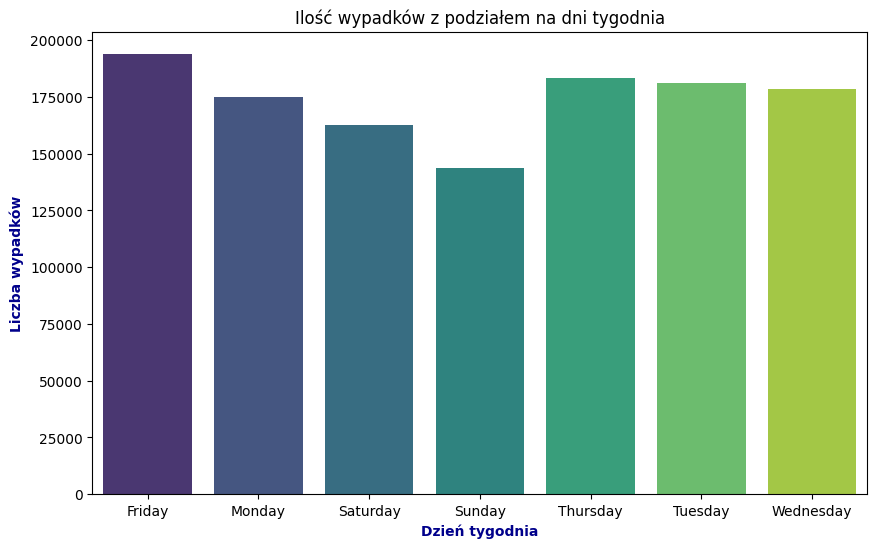

In [133]:
# BLOK RESERT
# import pandas as pd
# import matplotlib.pyplot as plt
# File_source = '../Data/nypd-motor-vehicle-collisions.csv'
# df = pd.read_csv(File_source)

# DUPLIKATY
df.drop_duplicates(subset='COLLISION_ID', keep='first', inplace=True)
num_unique_ids = df['COLLISION_ID'].nunique()
print("Liczba unikalnych ID po usunięciu duplikatów:", num_unique_ids)

# BLOK ZBIORU DANYCH
df['ACCIDENT DATE'] = pd.to_datetime(df['ACCIDENT DATE'])
df['DAY OF WEEK'] = df['ACCIDENT DATE'].dt.day_name()

daily_counts = df['DAY OF WEEK'].value_counts()

daily_counts = daily_counts.sort_index()

# WYKRES
plt.figure(figsize=(10, 6))
sns.barplot(x=daily_counts.index, y=daily_counts.values, palette='viridis')
plt.xlabel('Dzień tygodnia', fontweight='bold', color='darkblue')
plt.ylabel('Liczba wypadków', fontweight='bold', color='darkblue')
plt.title('Ilość wypadków z podziałem na dni tygodnia')
plt.show()



In [ ]:
# WNIOSKI:
#     NAJNIEBEZPIECZNIEJSZY DZIEŃ TYGODNIA DO ŻYCIA W NOWYM JORKU TO PONIEDZIAŁEK! RÓŒNIEŻ W SIERPNIU 2019 ROKU!

# PONIŻSZY WYKRES MOŻNA ŁATWO PRZESTAWIĆ NA INNY ZAKRES DAT:
#     # =>>>>MIESIĄC I ROK
# selected_month = 8  # Wybrany miesiąc (np. sierpień)
# selected_year = 2019  # Wybrany rok

Liczba unikalnych ID po usunięciu duplikatów: 1217957


/tmp/ipykernel_23378/1540393670.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['DAY OF WEEK'] = filtered_df['ACCIDENT DATE'].dt.day_name()


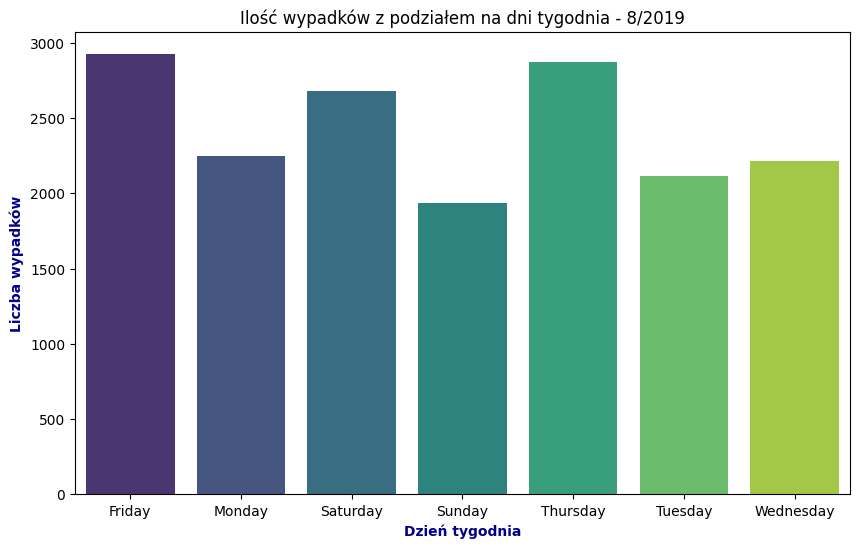

In [137]:
# BLOK RESERT
# import pandas as pd
# import matplotlib.pyplot as plt
# File_source = '../Data/nypd-motor-vehicle-collisions.csv'
# df = pd.read_csv(File_source)

# DUPLIKATY
df.drop_duplicates(subset='COLLISION_ID', keep='first', inplace=True)
num_unique_ids = df['COLLISION_ID'].nunique()
print("Liczba unikalnych ID po usunięciu duplikatów:", num_unique_ids)

# BLOK ZBIORU DANYCH
df['ACCIDENT DATE'] = pd.to_datetime(df['ACCIDENT DATE'])

# =>>>>MIESIĄC I ROK
selected_month = 8  # Wybrany miesiąc (np. sierpień)
selected_year = 2019  # Wybrany rok

filtered_df = df[(df['ACCIDENT DATE'].dt.month == selected_month) & (df['ACCIDENT DATE'].dt.year == selected_year)]
filtered_df['DAY OF WEEK'] = filtered_df['ACCIDENT DATE'].dt.day_name()

# df_unique_ids = filtered_df.drop_duplicates(subset=['COLLISION_ID'])
# daily_counts = df_unique_ids['DAY OF WEEK'].value_counts().sort_index()

# WYKRES
plt.figure(figsize=(10, 6))
sns.barplot(x=daily_counts.index, y=daily_counts.values, palette='viridis')
plt.xlabel('Dzień tygodnia', fontweight='bold', color='darkblue')
plt.ylabel('Liczba wypadków', fontweight='bold', color='darkblue')
plt.title(f'Ilość wypadków z podziałem na dni tygodnia - {selected_month}/{selected_year}')

plt.show()